# t-隨機鄰近嵌入法(t-distributed stochastic neighbor embedding)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# MNIST Dataset

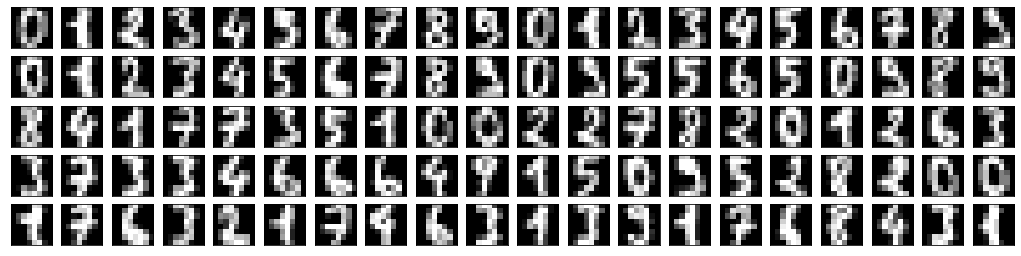

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X=(digits.data/16)
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# Nearest Neighbor

In [3]:
from scipy.spatial.distance import cdist
def Nearest_Neighbor(X,n_neighbors):
    distance = cdist(X,X,"euclidean")
    neighbors_index=np.argsort(distance,axis=1)[:,1:n_neighbors+1]
    neighbors=np.sort(distance,axis=1)[:,1:n_neighbors+1]
    return neighbors,neighbors_index

# Binary search for sigmas of conditional Gaussians

In [4]:
import math
def _binary_search_perplexity(neighbors,neighbors_index,perplexity,verbose):
    EPSILON_DBL = 1e-8
    PERPLEXITY_TOLERANCE = 1e-5
    n_steps = 100
    n_samples,n_neighbors  = neighbors.shape
    using_neighbors = n_neighbors < n_samples
    beta_sum = 0.0
    desired_entropy = math.log(perplexity)
    P = np.zeros((n_samples, n_samples), dtype=np.float64)
    for i in tqdm(range(n_samples)):
        beta_min = -np.Inf
        beta_max = np.Inf
        beta = 1.0
        for l in range(n_steps):
            sum_Pi = 0.0
            P[i,neighbors_index[i]]=np.exp(-neighbors[i]* beta)
            sum_Pi=np.sum(P[i,:])
            if sum_Pi == 0.0:
                sum_Pi = EPSILON_DBL
            P[i,:]/=sum_Pi
            sum_disti_Pi=np.sum(P[i,neighbors_index[i]]*neighbors[i])
            entropy = math.log(sum_Pi) + beta * sum_disti_Pi
            entropy_diff = entropy - desired_entropy
            if math.fabs(entropy_diff) <= PERPLEXITY_TOLERANCE:
                break
            if entropy_diff > 0.0:
                beta_min = beta
                if beta_max == np.Inf:
                    beta *= 2.0
                else:
                    beta = (beta + beta_max) / 2.0
            else:
                beta_max = beta
                if beta_min == -np.Inf:
                    beta /= 2.0
                else:
                    beta = (beta + beta_min) / 2.0
        beta_sum += beta
    return P

# Principal Component Anlysis

In [5]:
def PCA(X,n_components,N):
    X_center=X-np.mean(X,axis=0)
    W,D,V=np.linalg.svd(X_center.T)
    X_embedded=np.dot(X_center,W[:,:n_components])
    return X_embedded

# KL Divergence

In [6]:
from scipy.spatial.distance import pdist
def _kl_divergence(X_embedded,P,N,n_components):
    MACHINE_EPSILON_ARRAY=np.ones(N)*np.finfo(np.double).eps
    dist=(cdist(X_embedded,X_embedded,"euclidean")**2+1)**-1
    Q = np.maximum(dist/np.sum(dist.ravel()),MACHINE_EPSILON_ARRAY)
    PQd = (P-Q)*dist
    grad=np.zeros(X_embedded.shape)
    for i in range(N):
        grad[i]=4*np.dot(PQd[i],X_embedded[i]-X_embedded)
    return grad

# Gradient Descent

In [7]:
def gradient_descent(Y,P,gradient,max_iter,learning_rate,momentum):
    for t in tqdm(range(max_iter)):
        if(t<1):
            pre_pre_Y=Y.copy()
            Y=pre_pre_Y-learning_rate*gradient
            pre_Y=Y.copy()
        else:
            Y=pre_Y-learning_rate*gradient+momentum*(pre_Y-pre_pre_Y)
            pre_pre_Y=pre_Y.copy()
            pre_Y=Y.copy()
        gradient=_kl_divergence(Y,P,N,n_components)
    return Y

# t-SNE

In [9]:
N,M=X.shape
n_neighbors=30
n_components=2
neighbors,neighbors_index=Nearest_Neighbor(X,n_neighbors)
early_exaggeration=12.0
MACHINE_EPSILON=np.finfo(np.double).eps
neighbors = neighbors.reshape(N, -1)
neighbors = neighbors.astype(np.float32, copy=False)
conditional_P = _binary_search_perplexity(neighbors,neighbors_index,30, 0)
indptr=np.linspace(0,N*n_neighbors,N+1).astype(int)
P = conditional_P + conditional_P.T
P/=(2*N)
X_embedded=PCA(X,n_components,N)
grad=_kl_divergence(X_embedded,P,N,n_components)
Y=X_embedded.copy()
gradient=grad.copy()
max_iter=750
learning_rate=200
momentum=0.2
X_sub=gradient_descent(Y,P*early_exaggeration,gradient,max_iter,learning_rate,momentum)

# Plot

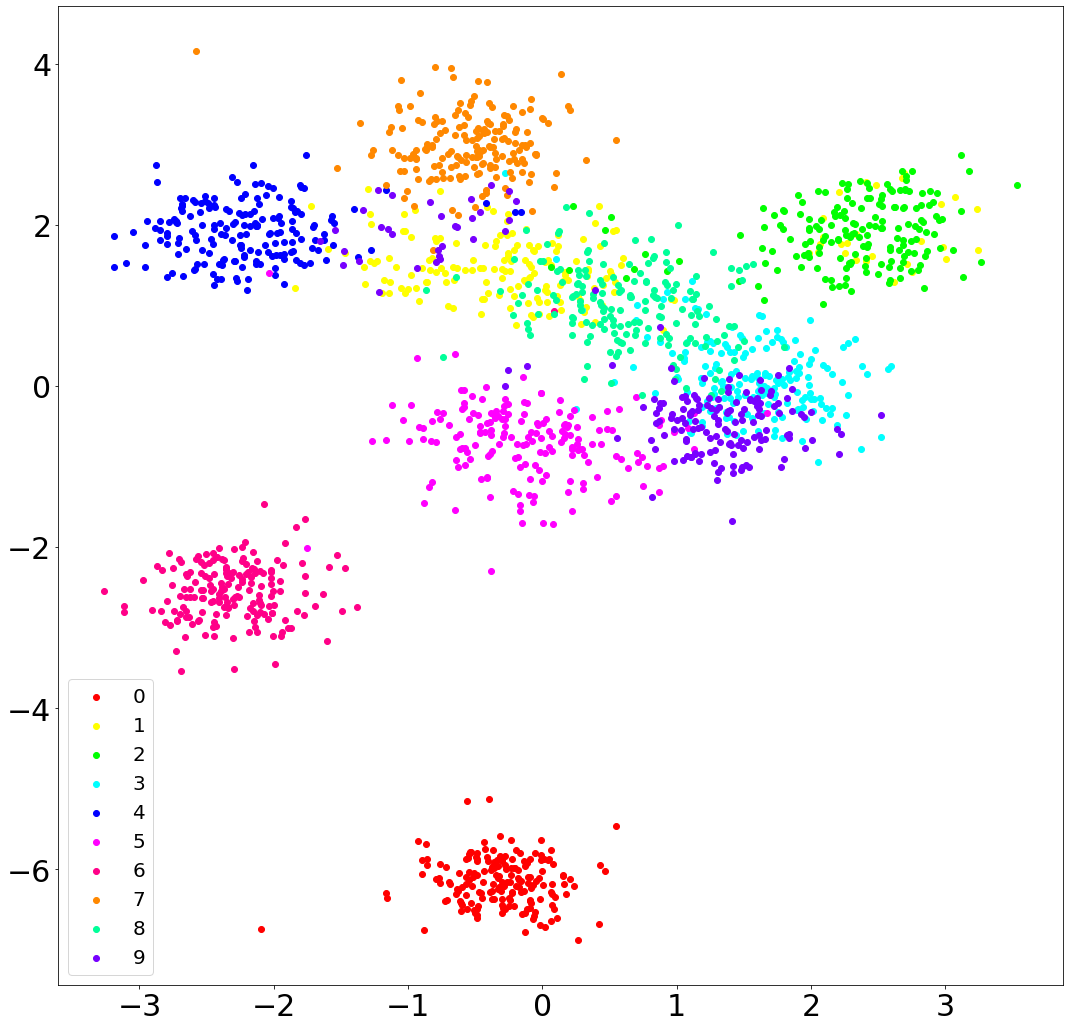

In [10]:
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF"]
plt.rcParams["figure.figsize"] = (18,18)
for i in range(0,10):
    BOOL=(y==i)
    plt.scatter(X_sub[BOOL,0],X_sub[BOOL,1],c=color[i],label=i)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.show()